In [1]:
! git init .
! git remote add origin https://github.com/VLSF/SDC
! git pull origin main

Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
From https://github.com/VLSF/SDC
 * branch            main       -> FETCH_HEAD
Already up to date.


In [2]:
import jax.numpy as jnp
from jax import config, random, jit, vmap, grad
from jax.lax import dot_general, scan
from functools import partial

config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

In [3]:
from misc import utils, Chebyshev, equations
from sdc_integrators import Picard_Lindelof
from integrators import Explicit_Euler

In [4]:
N_points = 10
N_PL = 100
t0, t1 = 0.0, 0.25
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0
key = random.PRNGKey(11)

results = {}
for equation in equations.equations_list:
    equation_data = equations.get_ODE(equation)
    F = equation_data["F"]
    inv_dF = equation_data["inv_dF"]

    key = random.split(key)[0]
    n = equations.equations_list[equation]
    u0 = random.normal(key, (n, 1))

    Residual = []
    values = u0 * jnp.ones((n, N_points))
    # values = Explicit_Euler.integrator(u0[:, 0], F, N_points, t0, t1)
    for i in range(N_PL):
        r = utils.residual(values, F, t0, t1)
        Residual.append(jnp.mean(jnp.linalg.norm(r, axis=1)))
        values = Picard_Lindelof.Picard_Lindelof(values, F, t0, t1)
    
    r = utils.residual(values, F, t0, t1)
    Residual.append(jnp.mean(jnp.linalg.norm(r, axis=1)))
    Residual = jnp.array(Residual)
    results[equation] = Residual

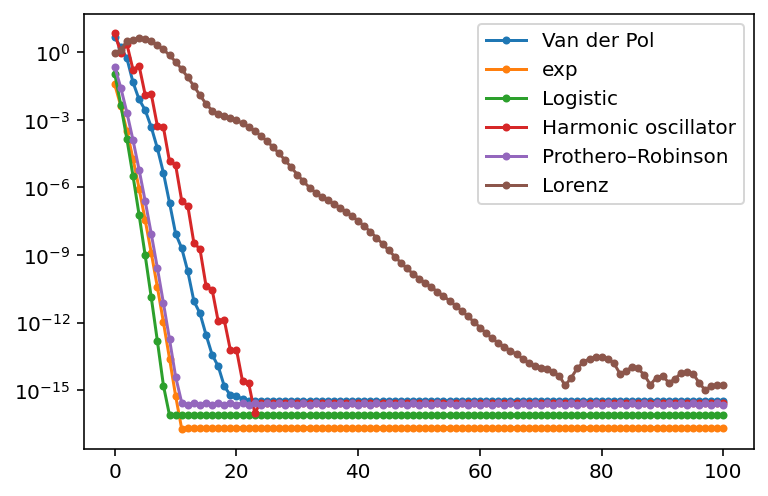

In [5]:
plt.yscale("log")
for equation in results:
    plt.plot(results[equation], ".-", label=equation)

plt.legend();